In [1]:
import os,sys
import csv
import copy
import math

import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np

from scipy.integrate import simps, trapz

sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from weno import get_left_flux,get_right_flux
from weno import get_stencil
from shallow_water_solver import shallow_solver
from avalanche_scheme import *
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext autoreload
%autoreload 2

********************************************************************
 Did you run "pip install" in your clawpack directory?
********************************************************************


Traceback (most recent call last):
  File "/usr/lib64/python2.7/site-packages/clawpack/riemann/__init__.py", line 60, in <module>
    import exner_1D
ImportError: No module named exner_1D


# Section 4 - An initial hump in unidirectional flow

The following is a simple test using the Gaussian Hump using the avalanche model. Typically I ran it once without the avalanche model and then again with the avalanche model to get an idea of the difference.

Again the eq. numbers referenced below are from: Long et al. (2008)

This test assumes that the sediment transport rate $q_{bed}$ is a power function of the current speed (e.g. Grass 1981) along with a steady flow in the channel and a rigid lid.

$q_{bed}=au^b$

$u=Q/h$

$h = s - z_b$

where $s$ is the datum, $a$ and $b$ are constants and $h$ is the water depth.

For the example in Section 4 in Long et al. (2008) the following values are used:

### Model constants

In [2]:
# Set up the constants

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

###Setup###
Setup the Mesh, Boundary and Initial Conditions

Grid dx = 1.0
Grid nx = 300


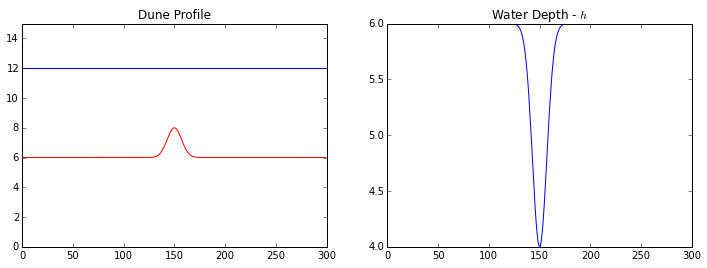

In [10]:
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

fig = plt.figure(figsize=(12, 4)) 
plt.subplot(1,2,1)
plt.plot(xc,z,'r') 
plt.plot(xc,surf,'b')
plt.ylim([0,15])
plt.title('Dune Profile')
plt.subplot(1,2,2)
plt.plot(xc,h,'b')  
plt.title('Water Depth - $h$')

### Simple Upwinding (First Order Time and Space)

Set up the model and run. This looks like simple upwinding. 

Extracting
Done


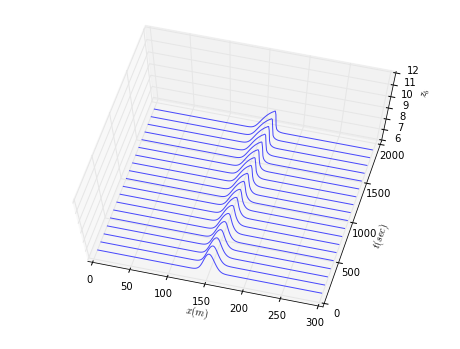

In [11]:
import math
simTime = 2000. # Runtime
dt = 0.1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
verts = []

extractionInterval = 100.
tsteps=[]

# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    # Now iterate over the domain
    for i in range(0,nx): 
        #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        zc[i] = zn[i]-(1./(1.-nP))*(dt/(2.0*dx))*(floc[1]-floc[0])
    
    # Apply the avalanche model
    #zc,iterations = avalanche_model(dx,xc,zc)
    #zc = z_updated.copy()
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
    
    if (n*dt==600):
        print 'Extracting'
        z600 = zc.copy() 
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)
    
print 'Done'
lines = LineCollection(verts)
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, 300)
ax.set_zlim3d(6, 12)
ax.set_ylim3d(0, 2000)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

#view_init(elev=None, azim=None)
ax.view_init(70, -75)

### Results

Comparing the results from the simple upwinding model for t=600 and 2000 s we see that our model appears to be moving a little to slow. The creast of the dune should be around 175 m however in this model it is approximately 170 m. 

In [74]:
from weno import get_exact_solution
x_600, z_a600 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,600.)
x_2000, z_a2000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,1500.)
np.shape(x_a),np.shape(z_a600)

((300,), (149,))

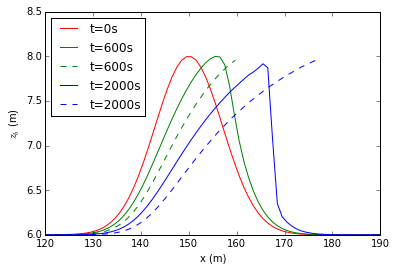

In [75]:
plt.plot(xc,z0,'r', label='t=0s') 
plt.plot(xc,z600,'g', label='t=600s')
plt.plot(x_600, z_a600,'g--', label='t=600s')
plt.plot(xc,zc, label='t=2000s')
plt.plot(x_2000, z_a2000,'b--', label='t=2000s')
plt.xlabel('x (m)')
plt.ylabel('$z_b$ (m)')
plt.xlim([120,190])
plt.ylim([6,6+2.5])
plt.legend(loc=2)

In [140]:
slopes = np.zeros(len(zc))
for i in range(len(xc)):
        zloc = get_stencil(zc,i,i+2)
        slopes[i] =get_slope(dx, zloc)
print min(slopes),max(slopes)


-38.8029704419 4.85776108861


In [4]:
plt.plot(xc,zc_no_avalanche)
plt.plot(xc,zc,'r')
plt.xlim([140,190])

NameError: name 'zc_no_avalanche' is not defined

## Running with the Shallow Water Equations

###October 21, 2015
Starting to review this code and understand where I left off. I think what is left to do is check the Exner code against the analytical model shown in Long et al (2008). From what I can tell, I re-wrote the WENO scheme to match the scheme in the paper and I think it worked better but still need to verify that this the case. 

Time step 10 of 1000 - bed_max_delta 0.0444460687248
Time step 20 of 1000 - bed_max_delta 0.0372965125929
Time step 30 of 1000 - bed_max_delta 0.0341526704662
Time step 40 of 1000 - bed_max_delta 0.0311817679711
Time step 50 of 1000 - bed_max_delta 0.0328955115822
Time step 60 of 1000 - bed_max_delta 0.0343726810987
Time step 70 of 1000 - bed_max_delta 0.0421565066984
Time step 80 of 1000 - bed_max_delta 0.0515285394164
Time step 90 of 1000 - bed_max_delta 0.0142077962554
Time step 100 of 1000 - bed_max_delta 0.0295001109487
Time step 110 of 1000 - bed_max_delta 0.0555120183104
Time step 120 of 1000 - bed_max_delta 0.03695859965
Time step 130 of 1000 - bed_max_delta 0.0300520078452
Time step 140 of 1000 - bed_max_delta 0.0337986814058
Time step 150 of 1000 - bed_max_delta 0.0514866036578
Time step 160 of 1000 - bed_max_delta 0.0129696962476
Time step 170 of 1000 - bed_max_delta 0.0471068535691
Time step 180 of 1000 - bed_max_delta 0.0141112313763
Time step 190 of 1000 - bed_max_delta 0

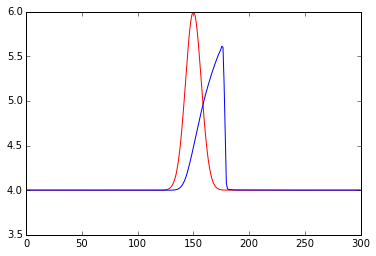

In [32]:
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

x = pyclaw.Dimension( 0, 300, 300, name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain, 2, 1)

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0
xc = state.grid.x.centers
#Set the bathymetry
#state.aux[0, :] = 0.8 * numpy.exp(-xc**2 / 0.2**2) - 1.0
# This is a bump upstream from a symmetrical dune
#state.q[0, :] = 0.1 * numpy.exp(-(xc + 0.4)**2 / 0.2**2) - state.aux[0, :]

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum

datum = 10.0
h0 = -6 + datum        # Water depth
s= 0.0 + datum            # Datum

beta = 0.01
z = np.zeros(300)
# Eq 66

z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z_hydro = z.copy()

# Set the flow conditions
a=0.005
b=3.0

plt.plot(xc,z,'r')

shw_slvr = shallow_solver(domain)
u, surf,h = shw_slvr.run(zc,s)

if np.isnan(u).any():
    # Get the flow
    print u
    raise ValueError('Failed to calculate the flow')

# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

nt = 1000   # Number of time steps
dt = 1.0 # Time step size (s)



cntr = 0




for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        # Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(z_hydro - zc))
    
    # Apply the avalanche model
    zc,iterations = avalanche_model(dx,xc,zc)
    #zc = z_updated.copy()
    
    if iterations > 0 or bed_max_delta > 0.05:
        u, surf,h = shw_slvr.run(zc,s);
        qbedload = a*u**b
        z_hydro = zc.copy()
        
    cntr += 1
    if cntr == 10:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))

plt.plot(xc,zc)
    

In [35]:
area_old = trapz(z, dx=dx)
area_new = trapz(zc, dx=dx)     

print(area_old,area_new)

(1231.4490770181103, 1231.4486240192196)


In [5]:
u, surf,h = shw_slvr.run(z,10);

2015-09-16 13:49:58,289 INFO CLAW: Solution 0 computed for time t=0.000000
2015-09-16 13:49:58,308 INFO CLAW: Solution 1 computed for time t=2.000000
2015-09-16 13:49:58,327 INFO CLAW: Solution 2 computed for time t=4.000000
2015-09-16 13:49:58,346 INFO CLAW: Solution 3 computed for time t=6.000000
2015-09-16 13:49:58,374 INFO CLAW: Solution 4 computed for time t=8.000000
2015-09-16 13:49:58,393 INFO CLAW: Solution 5 computed for time t=10.000000


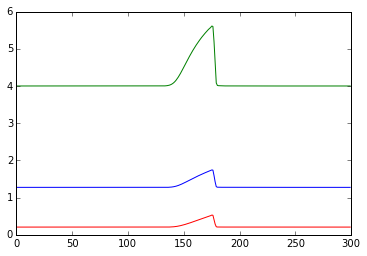

In [33]:
plt.plot(u)
plt.plot(zc)
plt.plot(qbedload*20.)

In [7]:
u

array([ 0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,  0.1147202 ,
        0.11472019,  0.11472019,  0.11472017,  0.11472015,  0.11472011,
        0.11472004,  0.11471991,  0.11471971,  0.11471936,  0.11471881,
        0.11471793,  0.11471655,  0.11471445,  0.11471129,  0.11470662,
        0.11469986,  0.11469027,  0.11467691,  0.11465864,  0.11463415,
        0.11460193,  0.11456035,  0.11450772,  0.11444235,  0.11436265,
        0.11426727,  0.11415518,  0.11402575,  0.11387885,  0.11